##  🚙 영국시장의 중고차 가격 예측 모델
#### <u> Day 2 Project: 중고차 가격 데이터 </u>  

작성자: 유재순  
작성일: 2026.02.09.월요일 

---
### 분석 로드맵
###### (추후 작성 예정)
---


### 1️⃣ 라이브러리 및 시각화 기본 셋팅

In [3]:
# ================
# 1. 라이브러리 및 시각화 기본 셋팅 
# ================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# ================
# 1) seaborn 테마
# ================
sns.set_theme(style="whitegrid", context="notebook")

# ================
# 2) 색상 팔레트
# ================
sns.set_palette("tab10")

# ================
# 3) 맥 한글 폰트 설정 
# ================
from matplotlib import rcParams
rcParams["font.family"] = "AppleGothic"

# 마이너스(-) 기호 깨짐 방지
rcParams["axes.unicode_minus"] = False

# 해상도 기본값
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 300

# matplotlib 기본 스타일 통일
plt.rcParams["axes.grid"] = True  # 그리드 켜기(whitegrid와 톤 맞춤)

# 막대/도형(패치) 테두리(아웃라인)
plt.rcParams["patch.edgecolor"] = "black"
plt.rcParams["patch.linewidth"] = 0.8


print("시각화 세팅 완료")

시각화 세팅 완료


### 2️⃣ 데이터 로드 및 기본구조 (병합)

In [4]:
car_df = pd.read_csv('cars.csv')

In [5]:
brand_df = pd.read_csv('brand.csv')

In [6]:
car_df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [7]:
brand_df.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [8]:
# =======
# cars.csv와 brand.csv를 join()으로 합치기
# =======

# 1) car_df: title에서 브랜드 키 추출
car_df["brand_key"] = car_df["title"].astype(str).str.split().str[0].str.lower()

# 2) brand_df: 브랜드 키 만들고(소문자), 중복 제거
brand_df["brand_key"] = brand_df["title"].astype(str).str.lower()
brand_df_unique = brand_df.drop_duplicates(subset="brand_key")

# 3) join으로 country 붙이기
merged_df = car_df.join(
    brand_df_unique.set_index("brand_key")[["country"]],
    on="brand_key"
)

print(merged_df.head())
print(merged_df[["title", "brand_key", "country"]].head())

            title  Price  Mileage(miles)  Registration_Year  Previous Owners  \
0     SKODA FABIA   6900           70189               2016              3.0   
1  VAUXHALL CORSA   1495           88585               2008              4.0   
2     HYUNDAI I30    949          137000               2011              NaN   
3      MINI HATCH   2395           96731               2010              5.0   
4  VAUXHALL CORSA   1000           85000               2013              NaN   

  Fuel type  Body type Engine Gearbox  Doors  Seats Emission Class  \
0    Diesel  Hatchback   1.4L  Manual    5.0    5.0         Euro 6   
1    Petrol  Hatchback   1.2L  Manual    3.0    5.0         Euro 4   
2    Petrol  Hatchback   1.4L  Manual    5.0    5.0         Euro 5   
3    Petrol  Hatchback   1.4L  Manual    3.0    4.0         Euro 4   
4    Diesel  Hatchback   1.3L  Manual    5.0    5.0         Euro 5   

  Service history brand_key         country  
0             NaN     skoda  Czech Republic  
1     

In [9]:
# =======
# country가 못 붙은 비율(0에 가까울수록 좋음)
# =======
merged_df["country"].isna().mean()



np.float64(0.0)

In [10]:
# =======
# 브랜드 분포
# =======
merged_df["brand_key"].value_counts().head(10)  # 브랜드 분포


brand_key
vauxhall         550
ford             410
volkswagen       272
bmw              269
peugeot          245
toyota           195
nissan           180
renault          175
mercedes-benz    168
audi             147
Name: count, dtype: int64

### 3️⃣ 변수(컬럼) 설명 테이블

In [11]:
# =======
# cars + brand 합친 데이터(merged_df)의 변수(피처) 설명 테이블 만들기
# - 컬럼명(영어), dtype, 예시값, 결측치 비율, 설명(간단)
# =======

import pandas as pd
from IPython.display import display

# 1) 변수 설명 사전(필요한 것만 간단히 채움: 없는 컬럼은 자동으로 빈칸)
col_desc = {
    "title": "차량 제목(브랜드+모델). brand_key 추출에 사용 가능.",
    "Price": "중고차 가격(타깃 y 후보).",
    "Mileage(miles)": "주행거리(마일). 값이 클수록 보통 가격↓.",
    "Registration_Year": "등록 연도(연식). 값이 클수록 보통 가격↑.",
    "Previous Owners": "이전 차주 수. 많을수록 감가 가능.",
    "Fuel type": "연료 종류(범주형). 예: Petrol/Diesel.",
    "Body type": "차체 형태(범주형). 예: Hatchback/SUV.",
    "Engine": "엔진/배기량 정보(문자열). 예: 1.4L → 숫자형 변환 가능.",
    "Gearbox": "변속기 종류(범주형). 예: Manual/Automatic.",
    "Doors": "문 개수(정수/범주).",
    "Seats": "좌석 수(정수/범주).",
    "Emission Class": "배출가스 등급(범주형). 예: Euro 6 → 숫자형 변환 가능.",
    "Service history": "정비 이력 여부(범주형). 예: Full/NaN.",
    "brand_key": "title에서 추출한 브랜드 키(조인/분석용).",
    "country": "브랜드 국가(brand.csv에서 결합된 컬럼).",
    # (만약 앞에서 만든 컬럼이 있으면 자동으로 설명 추가)
    "engine_liters": "Engine에서 추출한 배기량(L, 실수).",
    "euro_class": "Emission Class에서 추출한 유로 등급(정수)."
}

# 2) 예시값(각 컬럼의 첫 번째 유효값) 뽑는 함수
def first_non_null(s):
    s2 = s.dropna()
    return s2.iloc[0] if len(s2) > 0 else None

# 3) 변수 설명 테이블 생성
var_table = pd.DataFrame({
    "컬럼명(영어)": merged_df.columns,
    "dtype": merged_df.dtypes.astype(str).values,
    "예시값": [first_non_null(merged_df[c]) for c in merged_df.columns],
    "결측치비율": [merged_df[c].isna().mean() for c in merged_df.columns],
    "설명": [col_desc.get(c, "") for c in merged_df.columns]
})

# 4) 보기 좋게(결측치비율 소수점 정리 + 정렬)
var_table["결측치비율"] = var_table["결측치비율"].round(3)
var_table = var_table.sort_values("결측치비율", ascending=False).reset_index(drop=True)

display(var_table)


,컬럼명(영어),dtype,예시값,결측치비율,설명
0,Service history,object,Full,0.854,정비 이력 여부(범주형). 예: Full/NaN.
1,Previous Owners,float64,3.0,0.383,이전 차주 수. 많을수록 감가 가능.
2,Emission Class,object,Euro 6,0.024,배출가스 등급(범주형). 예: Euro 6 → 숫자형 변환 가능.
3,Engine,object,1.4L,0.012,엔진/배기량 정보(문자열). 예: 1.4L → 숫자형 변환 가능.
4,Seats,float64,5.0,0.009,좌석 수(정수/범주).
5,Doors,float64,5.0,0.007,문 개수(정수/범주).
6,Price,int64,6900,0.000,중고차 가격(타깃 y 후보).
7,Body type,object,Hatchback,0.000,차체 형태(범주형). 예: Hatchback/SUV.
8,Fuel type,object,Diesel,0.000,연료 종류(범주형). 예: Petrol/Diesel.
9,Registration_Year,int64,2016,0.000,등록 연도(연식). 값이 클수록 보통 가격↑.


###  4️⃣ 데이터 전처리

In [12]:
merged_df.describe()

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats
count,3687.000000,3.687000e+03,3687.000000,2276.000000,3662.000000,3652.000000
mean,5787.301058,8.132854e+04,2011.846216,2.807557,4.321409,4.900329
std,4480.629885,3.941718e+04,5.082387,1.546028,0.986760,0.577046
min,400.000000,1.000000e+00,1953.000000,1.000000,2.000000,2.000000
25%,2490.000000,5.698400e+04,2008.000000,2.000000,3.000000,5.000000
50%,4000.000000,8.000000e+04,2012.000000,3.000000,5.000000,5.000000
75%,7995.000000,1.030000e+05,2015.500000,4.000000,5.000000,5.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000,5.000000,7.000000


In [13]:
# =======
# 카테고리형 변수를 숫자 형태로 변환하기
# (Engine, Emission Class)
# =======

print(merged_df.columns)

# 1) Engine: "1.4L" 같은 문자열에서 숫자만 뽑아 float(실수)로 변환
merged_df["engine_liters"] = (
    merged_df["Engine"]
    .astype(str)                               # 문자열로 변환
    .str.extract(r"([\d\.]+)", expand=False)   # 숫자/점(.)만 추출
    .astype(float)                             # 실수(float)로 변환
)

# 2) Emission Class: "Euro 6" 같은 문자열에서 숫자만 뽑아 int(정수)로 변환
#    - 예: "Euro 6" -> "6" -> 6
merged_df["euro_class"] = (
    merged_df["Emission Class"]
    .astype(str)                               # 문자열로 변환
    .str.extract(r"(\d+)", expand=False)       # 숫자(0-9)만 추출
    .astype(float)                             # 결측 대비해 일단 float로
    .astype("Int64")                           # 판다스 정수형(결측 허용)으로 변환
)

# 3) 변환 결과 확인(상위 10개)
print(merged_df[["Engine", "engine_liters", "Emission Class", "euro_class"]].head(10))


Index(['title', 'Price', 'Mileage(miles)', 'Registration_Year',
       'Previous Owners', 'Fuel type', 'Body type', 'Engine', 'Gearbox',
       'Doors', 'Seats', 'Emission Class', 'Service history', 'brand_key',
       'country'],
      dtype='object')
  Engine  engine_liters Emission Class  euro_class
0   1.4L            1.4         Euro 6           6
1   1.2L            1.2         Euro 4           4
2   1.4L            1.4         Euro 5           5
3   1.4L            1.4         Euro 4           4
4   1.3L            1.3         Euro 5           5
5   2.0L            2.0         Euro 4           4
6   1.6L            1.6         Euro 4           4
7   1.2L            1.2         Euro 4           4
8   2.3L            2.3            NaN        <NA>
9   1.6L            1.6         Euro 4           4


In [14]:
# =======
# 결측치 처리하기
# 1) Service history 결측치 -> 'Unknown' 채우기
# 2) 결측치가 일정 개수 이상인 행(row) 제거하기
# =======

# 0) 기준: 한 행에 결측치가 몇 개 이상이면 삭제할지 설정
MISSING_THRESHOLD = 3 

# 1) Service history 결측치 채우기
merged_df["Service history"] = merged_df["Service history"].fillna("Unknown")

# 2) 각 행(row)마다 결측치 개수 세기
missing_cnt = merged_df.isna().sum(axis=1)

# 3) 결측치가 기준 이상인 행 제거
clean_df = merged_df.loc[missing_cnt < MISSING_THRESHOLD].copy()

# =======
# (추가) Previous Owners 결측치 처리: 중앙값으로 채우기
# =======
clean_df["Previous Owners"] = clean_df["Previous Owners"].fillna(clean_df["Previous Owners"].median())


# 4) 전/후 확인 출력
print("원본 행 개수:", len(merged_df))
print("정제 후 행 개수:", len(clean_df))
print("삭제된 행 개수:", len(merged_df) - len(clean_df))

print("\n[Service history 값 분포(정제 후)]")
print(clean_df["Service history"].value_counts(dropna=False).head(10))


원본 행 개수: 3687
정제 후 행 개수: 3609
삭제된 행 개수: 78

[Service history 값 분포(정제 후)]
Service history
Unknown    3073
Full        536
Name: count, dtype: int64


---
####
Service history는 결측이 85%이상, 정보가 없는 상태라서, 삭제시 데이터가 너무 많이  날아갈 수 있으므로, 'Unknown'으로 채워서 정비 이력 정보가 없음/미기재를 하나의 상태(범주)로  학습/분석 함. 'Unknown'이 많을수로 '정비 이력 미기재' 차량이 많다는 뜻.

### 5️⃣ 스케일링(Scaling)

In [15]:
# =======
# 가격예측용 스케일링 (데이터 누수 방지)
# - train에서만 fit
# - test에는 transform만 적용
# =======

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) 타깃(y)와 변수/피쳐(X) 분리
target = "Price"

# 가격예측에 쓸 수치형 변수/피처(Price 제외)
feature_cols = [
    "Mileage(miles)",
    "Registration_Year",
    "engine_liters",
    "euro_class",
    "Doors",
    "Seats",
    "Previous Owners"
]
feature_cols = [c for c in feature_cols if c in clean_df.columns]

# 2) 모델 입력용 데이터만 추림 + 결측 제거(간단 처리)
model_df = clean_df[feature_cols + [target]].dropna()

X = model_df[feature_cols]
y = model_df[target]

# 3) train/test 분리
# test_size=0.2 : 80% train, 20% test
# random_state : 항상 같은 분할 결과(재현성)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 스케일러 준비 (train에서만 fit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform
X_test_scaled = scaler.transform(X_test)         # transform만 (누수 방지)

# 5) 결과를 DataFrame으로 복원(컬럼명 유지)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=feature_cols, index=X_test.index)

print("학습용 X shape:", X_train_scaled_df.shape)
print("테스트용 X shape:", X_test_scaled_df.shape)
X_train_scaled_df.head()


학습용 X shape: (2874, 7)
테스트용 X shape: (719, 7)


,Mileage(miles),Registration_Year,engine_liters,euro_class,Doors,Seats,Previous Owners
1153,0.731892,-0.199004,-0.627009,-1.014481,0.689725,0.179925,0.110141
182,0.724677,-1.046321,-0.004763,-1.014481,0.689725,0.179925,-0.712056
1513,1.008380,-0.622663,-0.004763,-1.014481,-0.322670,0.179925,-0.712056
1137,-0.353885,0.436483,-0.834424,1.204406,-1.335066,-1.532342,0.110141
1444,0.005635,0.012825,0.202652,0.094963,0.689725,0.179925,0.110141


#### 
💡 단위/범위가 다른 수치형 변수들을 “같은 기준”으로 맞추기(변수간 영향력이 공정해짐)


### 6️⃣ PCA(주성분 분석 및 추출)
### 누적 설명분산비율(cumulative explained variance) ≥ 0.70 를 만족하는 최소 주성분(개수) 찾기!
(1) PCA 학습은 train에서만 fit, (2) test는 transform만, 데이터 누수 방지 함    
(2) 산점도 확인 train/test   

In [28]:
# =======
# 누적 설명분산비율 70% 이상을 만족하는 "최소" 주성분 개수 찾기 + PCA 학습
# - 전제: X_train_scaled_df (스케일된 학습용 X, DataFrame) 존재
# =======

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

TARGET_VAR = 0.70  # 목표 누적 설명분산비율(70%)

# 1) PCA를 전체 성분으로 먼저 fit (변수 개수만큼 PC 생성)
pca_full = PCA()
pca_full.fit(X_train_scaled_df)

# 2) 누적 설명분산비율 계산
cum_evr = np.cumsum(pca_full.explained_variance_ratio_)

# 3) 70% 이상이 되는 "최소" PC 개수 찾기
# - np.argmax: 조건을 처음 만족하는 위치(인덱스) 반환
# - +1 하는 이유: 인덱스는 0부터 시작, PC 개수는 1부터 시작
n_components_min = np.argmax(cum_evr >= TARGET_VAR) + 1

print("최소 주성분 개수:", n_components_min)
print("해당 누적 설명분산비율:", round(cum_evr[n_components_min - 1], 4))

# 4) 그 최소 개수로 PCA 다시 학습
pca = PCA(n_components=n_components_min, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_df)

# 5) (옵션) PCA 결과를 DataFrame으로 (PC1, PC2, ...)
train_pca_df = pd.DataFrame(
    X_train_pca,
    index=X_train_scaled_df.index,
    columns=[f"PC{i+1}" for i in range(n_components_min)]
)

print("\ntrain_pca_df shape:", train_pca_df.shape)

# 6) (옵션) 로딩(변수 기여도) 표 만들기
loading_df = pd.DataFrame(
    pca.components_.T,
    index=X_train_scaled_df.columns,
    columns=[f"PC{i+1}" for i in range(n_components_min)]
)

print("\n[로딩(변수 기여도) 표 - PC1 절댓값 기준 정렬]")
print(loading_df.reindex(loading_df["PC1"].abs().sort_values(ascending=False).index).head(20))


최소 주성분 개수: 3
해당 누적 설명분산비율: 0.7279

train_pca_df shape: (2874, 3)

[로딩(변수 기여도) 표 - PC1 절댓값 기준 정렬]
                        PC1       PC2       PC3
Registration_Year  0.558600 -0.007688  0.188146
euro_class         0.539068 -0.009441  0.237842
Mileage(miles)    -0.385369  0.221200  0.290465
Previous Owners   -0.356555  0.010924 -0.412396
engine_liters     -0.293732  0.169997  0.779721
Doors              0.183700  0.649092 -0.194628
Seats              0.041297  0.707520 -0.088016


---
#### 최소 주성분 개수: 3  
해당 누적 설명분산비율: 0.7279 (= 72.79%):7개 수치변수를 3차원 압축, 원본 변동(정보) 약 72.8% 담고 있음.  
train_pca_df shape: (2874, 3): 2874대 차량, 각 차량마다 pc1, pc2, pc3 점수 3개로 표현.  
- 로딩(변수 기여도): 절대값이 클수록 pc를 만드는데 더 큰역활을 함. (+/-)부호는 방향.

✅ PC1: PC1은 “전반적 차량 컨디션/신형성(=가치)”을 요약하는 축   
PC1은 거의 “차량의 ‘신형/규제등급 좋음’ vs ‘많이 탄/이력 복잡’” 축으로 보임.  
Registration_Year(연식)이 크고(+), euro_class(배출 규제 등급)이 높고(+)    
반대로 Mileage(주행거리)는 적고(-), Previous Owners(이전 차주 수)는 적고(-)    
→ PC1 점수가 “큰” 차량은 대체로 더 신형 + 친환경등급 높음 + 덜 굴러다님 + 소유자 적음 쪽 성격.  
✅ PC2: 로딩 큰것, Seats, Doors, Mileage.  
거의 “차량 크기/수용 능력(좌석/문)” 축. 
PC2가 크면: 좌석 많고, 문 많고(대형/패밀리 쪽 성향),  PC2가 작으면: 좌석/문 적은 소형차 성향.  
✅ PC3: engine_liters 압도적 큼.  
거의 “엔진 크기(배기량)” 중심 축이야.  
engine_liters가 PC3을 사실상 지배하고 있음.  
→ PC3 점수가 크면: 배기량 큰 차(힘/성능 쪽), 작으면: 배기량 작은 차(경제형).  

In [17]:
print("PC1 누적:", round(cum_evr[0], 4))
print("PC1+PC2 누적:", round(cum_evr[1], 4))
print("PC1+PC2+PC3 누적:", round(cum_evr[2], 4))

PC1 누적: 0.384
PC1+PC2 누적: 0.5984
PC1+PC2+PC3 누적: 0.7279


각 PC 설명분산비율: [0.38400883 0.21443132 0.12942397]
누적 설명분산비율: [0.38400883 0.59844016 0.72786413]


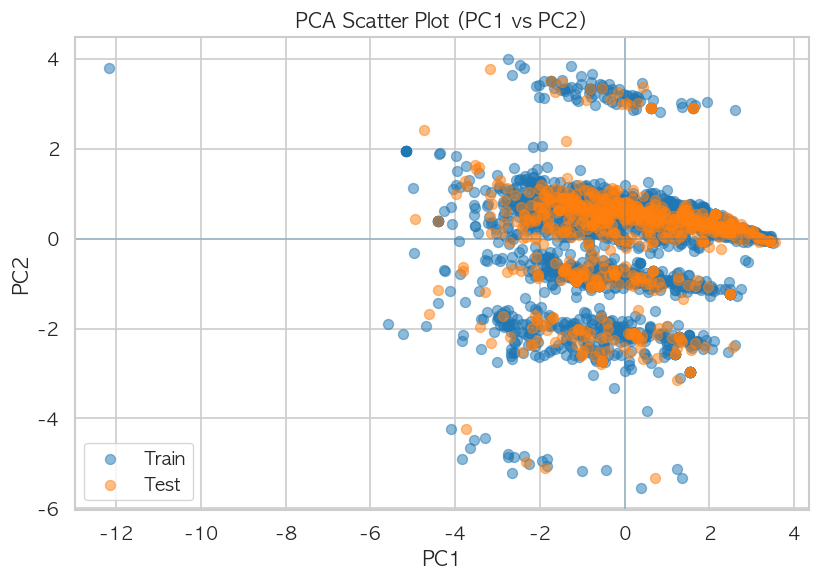

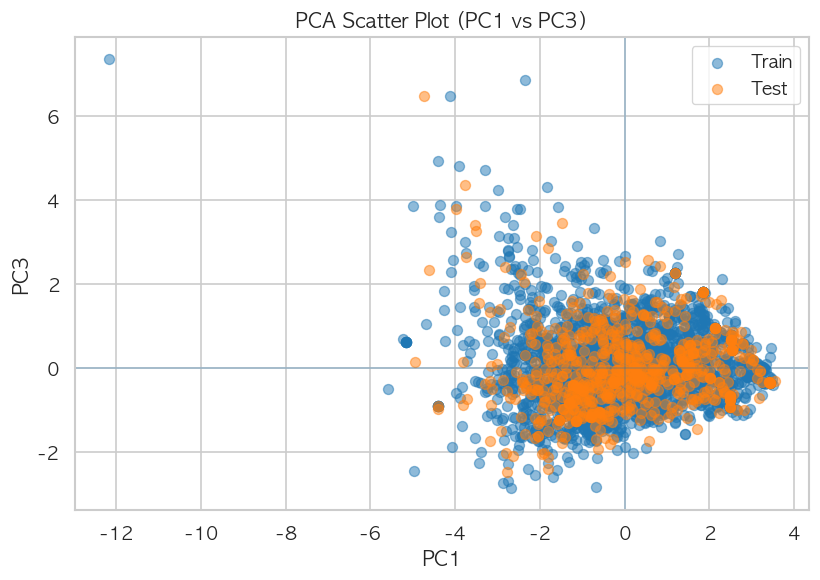

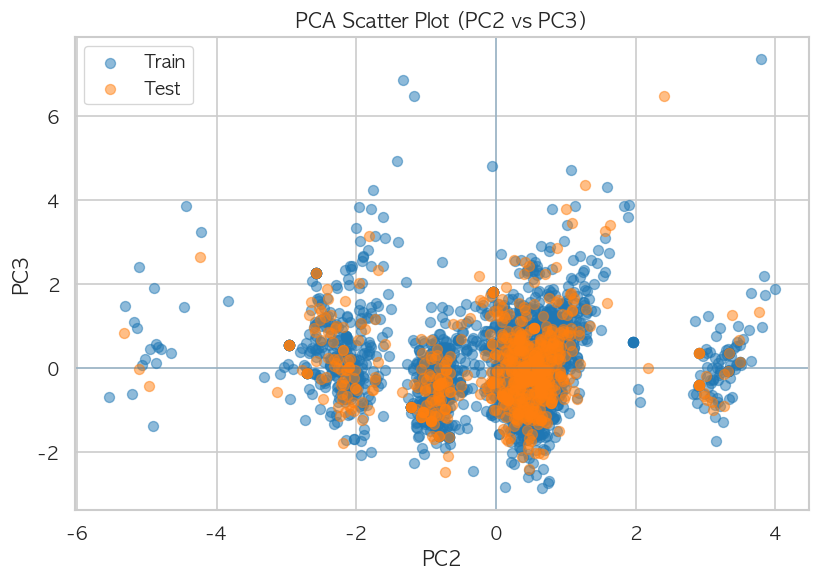

In [35]:
# =======
# train fit, test transform + PC1 ~ PC3 산점도 그리기
# =======

# ✅ 1) 70% 이상 만족 최소 k = 3 이므로 고정
k = 3
pca = PCA(n_components=k, random_state=42)

# ✅ 2) PCA는 train에서만 fit (데이터 누수 방지)
X_train_pca = pca.fit_transform(X_train_scaled)   # 학습+변환
X_test_pca  = pca.transform(X_test_scaled)        # 변환만

# ✅ 3) 결과를 DataFrame으로 보기 좋게 만들기
pc_cols = [f"PC{i+1}" for i in range(k)]
train_pca_df = pd.DataFrame(X_train_pca, columns=pc_cols, index=X_train.index)
test_pca_df  = pd.DataFrame(X_test_pca,  columns=pc_cols, index=X_test.index)

# ✅ 4) 누적 설명분산비율 확인
evr = pca.explained_variance_ratio_
cum_evr = evr.cumsum()
print("각 PC 설명분산비율:", evr)
print("누적 설명분산비율:", cum_evr)

# ✅ 5) 2D 산점도 3장(PC1-2, PC1-3, PC2-3)
pairs = [("PC1", "PC2"), ("PC1", "PC3"), ("PC2", "PC3")]

for a, b in pairs:
    plt.figure(figsize=(7, 5))
    plt.scatter(train_pca_df[a], train_pca_df[b], alpha=0.5, label="Train")
    plt.scatter(test_pca_df[a],  test_pca_df[b],  alpha=0.5, label="Test")
    plt.axhline(0, linewidth=1, alpha=0.3)
    plt.axvline(0, linewidth=1, alpha=0.3)
    plt.title(f"PCA Scatter Plot ({a} vs {b})")
    plt.xlabel(a)
    plt.ylabel(b)
    plt.legend()
    plt.tight_layout()
    plt.show()


### 7️⃣ 국가별 총 브랜드 개수는?

In [ ]:
# =======
# 국가별 "총 브랜드 개수" 구하기
# - brand_df 기준으로 보는 게 가장 정확함 (브랜드 중복 제거가 쉬움)
# =======

# 1) 브랜드 키 만들기 (소문자 통일)
tmp_brand = brand_df.copy()
tmp_brand["brand_key"] = tmp_brand["title"].astype(str).str.lower().str.strip()

# 2) (brand_key, country) 중복 제거 -> "브랜드 1개 = 1행" 개념 만들기
brand_unique = tmp_brand.drop_duplicates(subset=["brand_key", "country"])

# 3) 국가별 브랜드 개수 세기
country_brand_counts = (
    brand_unique.groupby("country")["brand_key"]
    .nunique()                      # nunique(): 유니크 개수
    .sort_values(ascending=False)   # 큰 순서대로 정렬
)

print("[국가별 총 브랜드 개수]")
print(country_brand_counts)



[국가별 총 브랜드 개수]
country
Japan             11
United Kingdom     8
Germany            6
United States      5
France             4
Italy              4
South Korea        4
Sweden             2
Czech Republic     1
Malaysia           1
Romania            1
Spain              1
Name: brand_key, dtype: int64


### 8️⃣ 상관관계 높은 변수 확인(수치형)

In [ ]:
# =======
# 상관관계 높은 변수(수치형) 찾기
# - clean_df 기준으로 확인 (정제 후 데이터)
# =======

import numpy as np

# 1) 수치형 컬럼만 선택
num_df = clean_df.select_dtypes(include=[np.number]).copy()

# 2) 상관계수(피어슨) 계산
corr = num_df.corr()  # corr(): 상관관계 행렬(표)

# 3) (중복 제거) 상관관계 쌍을 1줄 리스트로 펼치기
corr_pairs = corr.unstack()                 # (변수1, 변수2) -> 값 형태로 펼침
corr_pairs = corr_pairs.dropna()

# 4) 자기 자신(상관=1) 제거 + 중복 쌍 제거
# - (A,B)와 (B,A)가 둘 다 나오므로 한쪽만 남기기
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.groupby(frozenset).first()  # 중복 제거 트릭

# 5) 절댓값(| |) 기준으로 상관 큰 것부터 보기
top_corr = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

print("[상관관계 절댓값 TOP 15]")
print(top_corr.head(15))

# 6) 임계값 기준으로 '높은 상관'만 보고 싶으면 (예: |corr| >= 0.7)
THRESH = 0.7
high_corr = top_corr[top_corr.abs() >= THRESH]

print(f"\n[|상관| >= {THRESH} 인 변수 쌍]")
print(high_corr if len(high_corr) > 0 else "해당 없음")


[상관관계 절댓값 TOP 15]
(Registration_Year, euro_class)         0.920095
(Registration_Year, Price)              0.775481
(Price, euro_class)                     0.697992
(Price, Mileage(miles))                -0.502463
(Seats, Doors)                          0.498174
(Registration_Year, Mileage(miles))    -0.442309
(Previous Owners, Registration_Year)   -0.416195
(Previous Owners, Price)               -0.405431
(Previous Owners, euro_class)          -0.379480
(euro_class, Mileage(miles))           -0.378377
(engine_liters, Mileage(miles))         0.333814
(engine_liters, Registration_Year)     -0.298682
(Previous Owners, Mileage(miles))       0.267319
(engine_liters, euro_class)            -0.264197
(Registration_Year, Doors)              0.217044
dtype: float64

[|상관| >= 0.7 인 변수 쌍]
(Registration_Year, euro_class)    0.920095
(Registration_Year, Price)         0.775481
dtype: float64


---
### 상관관계(correlation):
상관계수 r, +1 에 가까움: 같이 증가/감소(양의 상관), 1에 가까움: 한쪽이 증가하면 다른쪽은 감소(음의 상관). 
0에 가까움: 선형(직선) 관계는 거의 없음    
- Registration_Year(연식) ↑ 하면 Price(가격) ↑ → r이 양수    
- Mileage(주행거리) ↑ 하면 Price ↓ → r이 음수   
|r| >= 0.7 같은 임계값(threshold)으로 강한 쌍만 필터: abs(r) >= 0.7 조건을 만족  
- 0.7은 “강한 상관”

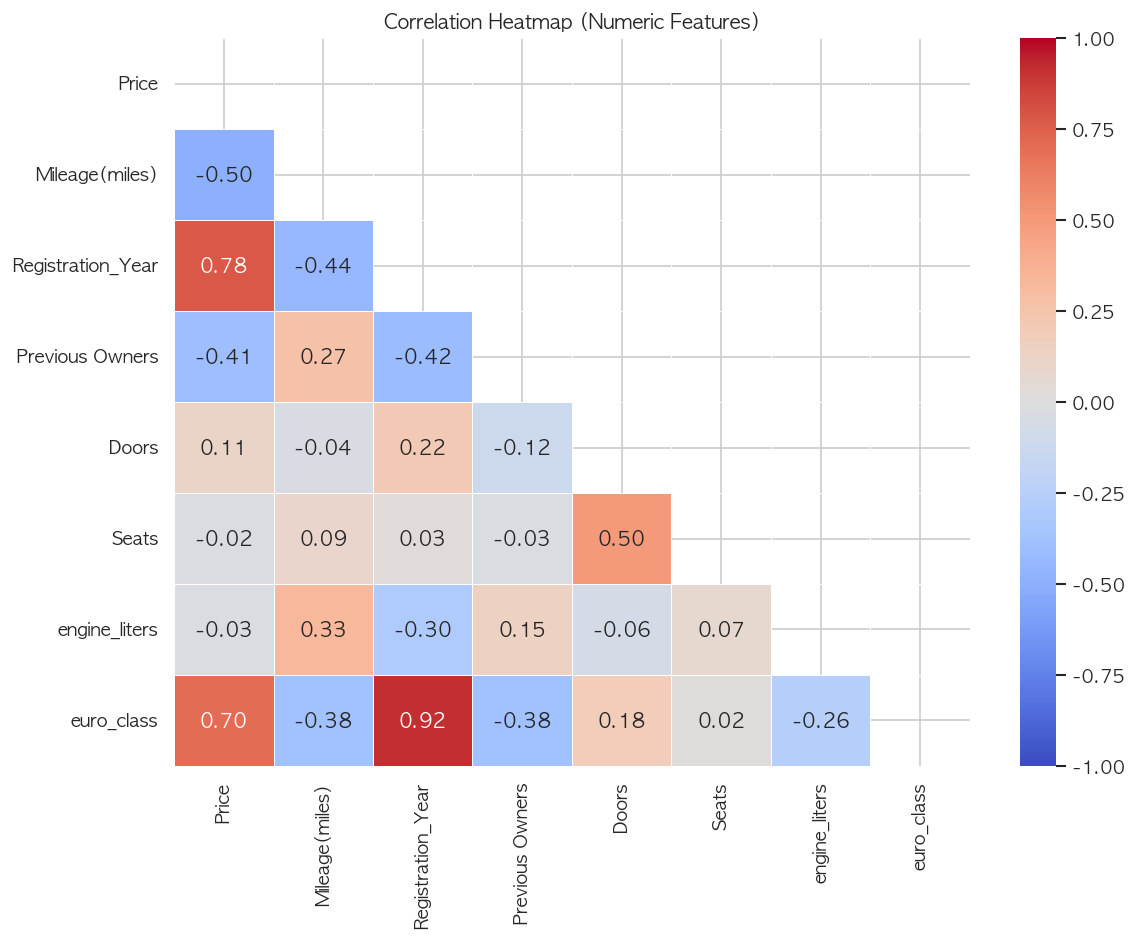

In [ ]:
# =======
# 상관관계 히트맵 (seaborn)
# - 수치형 컬럼들 간 상관계수(r)를 계산해서 시각화
# =======

# 1) 히트맵에 사용할 "수치형 컬럼"만 선택
num_df = clean_df.select_dtypes(include=[np.number])

# 2) 상관관계(피어슨) 계산: 각 변수쌍마다 r(-1~+1)
corr = num_df.corr(method="pearson")

# 3) 중복(대칭) 영역 가리기 위한 마스크 만들기(선택)
# - np.triu: 상삼각(위쪽 삼각형) True로 만들어서 한쪽만 보이게 함
mask = np.triu(np.ones_like(corr, dtype=bool))

# 4) 그림 크기 설정
plt.figure(figsize=(10, 8))

# 5) 히트맵 그리기
sns.heatmap(
    corr,
    mask=mask,              # 중복 제거(한쪽만 표시)
    annot=True,             # 숫자(상관계수) 표시
    fmt=".2f",              # 소수 2자리로 표시
    cmap="coolwarm",        # 색상(음수~양수 대비)
    vmin=-1, vmax=1,        # 범위 고정(비교 쉬움)
    linewidths=0.5          # 칸 경계선
)

plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()
